# Nearby Restaurant Hotspots Analysis in Melbourne by Small Clue Area

**Authored by:** Tharaka Sandamal

**Duration:** 90 mins  
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Analysis, Pandas, Data Visualization


## Scenario

As office workers in Melbourne, finding a convenient and available place to eat during lunch can be a challenge due to limited seating capacity and high business activity. The goal is to identify areas in Melbourne that need more restaurants, cafes, or bistros based on the current seating capacity and nearby business activity. This analysis will help urban planners and business owners make informed decisions about where to establish new eateries to meet the demand.

At the end of this use case you will:
- Learn how to clean and merge multiple datasets using Pandas.
- Perform exploratory data analysis to understand the relationship between seating capacity and business activity.
- Use data visualization techniques to identify potential hotspots for new restaurants.
- Generate actionable insights to inform decision-making in urban planning and business development.

Melbourne is a bustling city with a significant number of office workers who frequently visit nearby cafes and restaurants for lunch. However, the availability of seating and the proximity of eateries to business hubs can affect their choices. This analysis aims to determine which areas in Melbourne need more dining options by analyzing datasets related to seating capacity, business activity, and land use. By combining these datasets, we can identify regions with high demand but insufficient seating capacity, guiding new restaurant openings to better serve the community.

## Project Stages


1. **Data Collection**:
   Download the necessary datasets.
   - [Cafes and Restaurants with Seating Capacity](https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/)
   - [Employment by Block by CLUE Industry](https://data.melbourne.vic.gov.au/explore/dataset/employment-by-block-by-clue-industry/information/)
   - [Blocks for Census of Land Use and Employment (CLUE)](https://data.melbourne.vic.gov.au/explore/dataset/blocks-for-census-of-land-use-and-employment-clue/information/?sort=-block_id&location=13,-37.81306,144.94413&basemap=mbs-7a7333)

2. **Data Cleaning and Preparation**:
   - Load the datasets into Pandas DataFrames.
   - Inspect and clean the data.
   - Merge the datasets on common fields.

3. **Data Analysis**:
   - Calculate the total seating capacity of cafes and restaurants per block.
   - Analyze the employment data to understand the density of workers per block.

4. **Determine Hotspots**:
   - Identify blocks with high business activity but low seating capacity.
   - Highlight areas with a mismatch between the number of employees and available seating.

5. **Visualization**:
   - Create visualizations to show areas with high demand for more restaurants/cafes.
   - Present findings in a clear and impactful manner.

### Expected Outcome
The expected outcome of this project is to identify specific areas in Melbourne that require additional restaurants, cafes, or bistros based on the analysis of seating capacity, business activity, and possibly pedestrian movement data. This will provide urban planners and business owners with actionable insights to make informed decisions about where to establish new dining options to meet the demand of office workers.




## Dataset Descriptions

1. **Cafes and Restaurants with Seating Capacity**:
   - This dataset contains information about cafes and restaurants in Melbourne, including their seating capacity.
   - [Link to Dataset](https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/)

2. **Employment by Block by CLUE Industry**:
   - This dataset provides employment information by block and industry within Melbourne, indicating the density of business activity.
   - [Link to Dataset](https://data.melbourne.vic.gov.au/explore/dataset/employment-by-block-by-clue-industry/information/)

3. **Blocks for Census of Land Use and Employment (CLUE)**:
   - This dataset includes detailed information about blocks in Melbourne, used for the Census of Land Use and Employment.
   - [Link to Dataset](https://data.melbourne.vic.gov.au/explore/dataset/blocks-for-census-of-land-use-and-employment-clue/information/?sort=-block_id&location=13,-37.81306,144.94413&basemap=mbs-7a7333)

# Package/Library Imports

In [3]:
# Importing from config file
from config import API_KEY  # import API_KEY from config file

# Standard library imports
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import StringIO

# External library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from sklearn.cluster import KMeans
import squarify
from matplotlib_venn import venn3
import folium
from folium.plugins import MarkerCluster
import json




# Read data using API

In [4]:
# **Preferred Method**: Export Endpoint

#Function to collect data 
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
    'select': '*',
    'limit': -1, # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': API_KEY #use if use datasets require API key permissions
    }

    # GET request
    response = requests.get(url, params=params)
    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset 
    else:
        print(f'Request failed with status code {response.status_code}')

# Read data using the function
cafe_df = collect_data('cafes-and-restaurants-with-seating-capacity')
emp_block_df = collect_data('employment-by-block-by-clue-industry')
block_df = collect_data('blocks-for-census-of-land-use-and-employment-clue')
Small_CLUE_area = collect_data('small-areas-for-census-of-land-use-and-employment-clue')

# Learn and explore the data

## Cafes/Restaurants with seating capacity

In [5]:
print(f'Shape of the cafe_df:\t{cafe_df.shape}')
cafe_df.head(5)

Shape of the cafe_df:	(60055, 15)


,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,industry_anzsic4_code,industry_anzsic4_description,seating_type,number_of_seats,longitude,latitude,location
0,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Indoor,230,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
1,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Outdoor,120,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
2,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Altius Coffee Brewers,"Shop , Ground , 517 Flinders Lane MELBOURNE 3000",4512,Takeaway Food Services,Seats - Outdoor,4,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
3,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Five & Dime Bagel,16 Flinders Lane MELBOURNE 3000,1174,Bakery Product Manufacturing (Non-factory based),Seats - Indoor,14,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
4,2017,11,103985,103985,562-564 Flinders Street MELBOURNE 3000,Melbourne (CBD),YHA Melbourne Central,562-564 Flinders Street MELBOURNE 3000,4400,Accommodation,Seats - Indoor,43,144.955635,-37.820595,"-37.82059511593975, 144.9556348088"


In [6]:
print('-'*20,'cafe_df Info','-'*20)
print()
# display all columns, non-null count and their data types
print(cafe_df.info())

-------------------- cafe_df Info --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60055 entries, 0 to 60054
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   census_year                   60055 non-null  int64  
 1   block_id                      60055 non-null  int64  
 2   property_id                   60055 non-null  int64  
 3   base_property_id              60055 non-null  int64  
 4   building_address              60055 non-null  object 
 5   clue_small_area               60055 non-null  object 
 6   trading_name                  60055 non-null  object 
 7   business_address              60055 non-null  object 
 8   industry_anzsic4_code         60055 non-null  int64  
 9   industry_anzsic4_description  60055 non-null  object 
 10  seating_type                  60055 non-null  object 
 11  number_of_seats               60055 non-null  int64  
 12  long

According to the above output there are number of null values in the cafe_df need to be addressed.

## Employment by block

In [7]:
print(f'Shape of the emp_block_df:\t{emp_block_df.shape}')
emp_block_df.head(5)

Shape of the emp_block_df:	(12394, 24)


,census_year,block_id,clue_small_area,accommodation,admin_and_support_services,agriculture_and_mining,arts_and_recreation_services,business_services,construction,education_and_training,...,information_media_and_telecommunications,manufacturing,other_services,public_administration_and_safety,real_estate_services,rental_and_hiring_services,retail_trade,transport_postal_and_storage,wholesale_trade,total_jobs_in_block
0,2022,4,Melbourne (CBD),0.0,0.0,0.0,362.0,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,38.0,368.0,0.0,1008.0
1,2022,5,Melbourne (CBD),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,6,Melbourne (CBD),0.0,0.0,0.0,203.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,47.0,0.0,0.0,647.0
3,2022,13,Melbourne (CBD),NaN,520.0,0.0,NaN,496.0,NaN,NaN,...,55.0,NaN,27.0,0.0,0.0,0.0,NaN,NaN,0.0,2379.0
4,2022,16,Melbourne (CBD),NaN,NaN,0.0,86.0,382.0,295.0,NaN,...,0.0,0.0,64.0,0.0,NaN,0.0,60.0,0.0,0.0,2404.0


In [8]:
print('-'*20,'emp_block_df Info','-'*20)
print()
# display all columns, non-null count and their data types
print(emp_block_df.info())

-------------------- emp_block_df Info --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12394 entries, 0 to 12393
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_year                               12394 non-null  int64  
 1   block_id                                  12394 non-null  int64  
 2   clue_small_area                           12394 non-null  object 
 3   accommodation                             9986 non-null   float64
 4   admin_and_support_services                10375 non-null  float64
 5   agriculture_and_mining                    11795 non-null  float64
 6   arts_and_recreation_services              8467 non-null   float64
 7   business_services                         10519 non-null  float64
 8   construction                              10319 non-null  float64
 9   education_and_training                    98

According to the above output there are number of null values in the emp_block_df need to be addressed.

## Blocks info

In [9]:
print(f'Shape of the block_df:\t{block_df.shape}')
block_df.head(5)

Shape of the block_df:	(606, 4)


,geo_point_2d,geo_shape,block_id,clue_area
0,"-37.788517214796904, 144.9421522923356","{""coordinates"": [[[144.9421360326, -37.7875659...",925,Parkville
1,"-37.78752314475404, 144.9428068448982","{""coordinates"": [[[144.9421360326, -37.7875659...",924,Parkville
2,"-37.78035632811396, 144.94536433435934","{""coordinates"": [[[144.9425926939, -37.7787229...",930,Parkville
3,"-37.80720183148242, 144.94336441344424","{""coordinates"": [[[144.9427148261, -37.8073238...",412,West Melbourne (Residential)
4,"-37.806706331914484, 144.94240782994808","{""coordinates"": [[[144.9427148261, -37.8073238...",410,West Melbourne (Residential)


In [10]:
block_df['block_id'] = block_df['block_id'].astype(str)

In [11]:
print('-'*20,'block_df Info','-'*20)
print()
# display all columns, non-null count and their data types
print(block_df.info())

-------------------- block_df Info --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_point_2d  606 non-null    object
 1   geo_shape     606 non-null    object
 2   block_id      606 non-null    object
 3   clue_area     606 non-null    object
dtypes: object(4)
memory usage: 19.1+ KB
None


According to the above output there is no missing values in the block_df.

# Data Preprocessing

## Cafes/Restaurants with seating capacity

**Identify Missing Values**

In [12]:
print('-'*20,'cafe_df missing values','-'*20)
print()
missing_values = cafe_df.isnull().sum()
print(missing_values[missing_values > 0])

-------------------- cafe_df missing values --------------------

longitude    527
latitude     527
location     527
dtype: int64


Based on the above output, the cafe_df contains missing values in the longitude, latitude, and location columns. It is not appropriate to impute these missing values using simple aggregate functions such as mean or median, as these columns represent critical geographical data. 

Additionally, we cannot drop these records at this stage because we are working with three datasets, and these records may still be valuable when we merge them together later. 

**Identify Duplicated Values**

In [13]:
# First, check for duplicates in the dataset
duplicates_count = cafe_df.duplicated().sum()

# Remove duplicates if any
cafes_df_cleaned = cafe_df.drop_duplicates()

# Check again for the number of duplicates after removing them
duplicates_after = cafes_df_cleaned.duplicated().sum()

# Display the result
print(f'Before cleaning, Number of duplicates\t:{duplicates_count}')
print(f'After cleaning, Number of duplicates\t:{duplicates_after}')

Before cleaning, Number of duplicates	:0
After cleaning, Number of duplicates	:0


**Handling Missing Values**

In [14]:


# Initialize the geocoder
geolocator = Nominatim(user_agent="cafe_geocoder")

# Function to get latitude and longitude based on address with retry logic and caching
cache = {}

def get_lat_long(address, retries=3):
    if address in cache:
        return cache[address]
    
    for attempt in range(retries):
        try:
            location = geolocator.geocode(address, timeout=10)
            if location:
                cache[address] = (location.latitude, location.longitude)
                return location.latitude, location.longitude
            else:
                return None, None
        except (GeocoderTimedOut, GeocoderServiceError):
            time.sleep(1)  # Wait before retrying
        except Exception as e:
            return None, None
    return None, None

# Identify rows with missing latitude and longitude
missing_lat_long = cafes_df_cleaned[cafes_df_cleaned['latitude'].isnull() & cafes_df_cleaned['longitude'].isnull()]

# Parallel processing using ThreadPoolExecutor
def geocode_row(idx, row):
    lat, long = get_lat_long(row['building_address'])
    return idx, lat, long

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(geocode_row, idx, row): idx for idx, row in missing_lat_long.iterrows()}
    for future in as_completed(futures):
        idx, lat, long = future.result()
        if lat is not None and long is not None:
            cafes_df_cleaned.at[idx, 'latitude'] = lat
            cafes_df_cleaned.at[idx, 'longitude'] = long

# Check how many missing values are left after the geocoding process
remaining_missing = cafes_df_cleaned[['latitude', 'longitude']].isnull().sum()

print("Remaining missing values after geocoding:")
print(remaining_missing)


Remaining missing values after geocoding:
latitude     92
longitude    92
dtype: int64


In [15]:
# Dropping rows with missing latitude and longitude values
cafes_df_cleaned = cafes_df_cleaned.dropna(subset=['latitude', 'longitude'])

# Verify that all missing values for latitude and longitude have been removed
remaining_missing_after_drop = cafes_df_cleaned[['latitude', 'longitude']].isnull().sum()

# Display the result to confirm no more missing values
remaining_missing_after_drop


latitude     0
longitude    0
dtype: int64

## Employment by block

**Missing Values**

In [16]:
print('-'*20,'emp_block_df missing values','-'*20)
print()
missing_values = emp_block_df.isnull().sum()
print(missing_values[missing_values > 0])

-------------------- emp_block_df missing values --------------------

accommodation                               2408
admin_and_support_services                  2019
agriculture_and_mining                       599
arts_and_recreation_services                3927
business_services                           1875
construction                                2075
education_and_training                      2553
electricity_gas_water_and_waste_services    2468
finance_and_insurance                       1578
food_and_beverage_services                  2628
health_care_and_social_assistance           2560
information_media_and_telecommunications    2298
manufacturing                               2309
other_services                              3280
public_administration_and_safety            1852
real_estate_services                        1791
rental_and_hiring_services                   860
retail_trade                                2510
transport_postal_and_storage                224

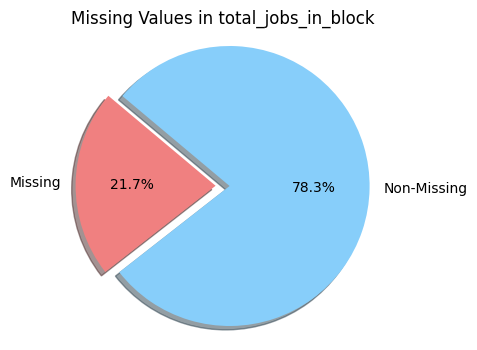

In [17]:
# Step 1: Count missing and non-missing values
missing_total_jobs_count = emp_block_df['total_jobs_in_block'].isnull().sum()
non_missing_total_jobs_count = emp_block_df['total_jobs_in_block'].notnull().sum()

# Create a dictionary for the counts
missing_data = {
    'Missing': missing_total_jobs_count,
    'Non-Missing': non_missing_total_jobs_count
}

# Step 2: Create a pie chart
labels = list(missing_data.keys())
sizes = list(missing_data.values())
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the slice for missing values

plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Missing Values in total_jobs_in_block')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

The above figure illustrates that approximately 21.7% of the values in the total_jobs_in_block column are missing. This is a significant issue that we need to handle properly. Because total number of jobs in each block is a key fact analyzing the hot spot for restaurants. otherwise, it could mislead the findings. 

The presence of such a substantial portion of missing data can introduce bias, lead to loss of information, and affect the accuracy and reliability of our analysis. Therefore, careful consideration and appropriate imputation methods are necessary to address this issue

**Impute Missing Values (Total Jobs)**

In [18]:
# Calculate the mean of total jobs in each block
block_mean_jobs = emp_block_df.groupby('block_id')['total_jobs_in_block'].transform('mean')

# Create a new column for the imputed total jobs in block
emp_block_df['total_jobs_in_block_imputed'] = emp_block_df.apply(
    lambda row: row['total_jobs_in_block'] if pd.notnull(row['total_jobs_in_block']) and row['total_jobs_in_block'] != 0
    else block_mean_jobs[row.name],
    axis=1
)

emp_block_df.head()

,census_year,block_id,clue_small_area,accommodation,admin_and_support_services,agriculture_and_mining,arts_and_recreation_services,business_services,construction,education_and_training,...,manufacturing,other_services,public_administration_and_safety,real_estate_services,rental_and_hiring_services,retail_trade,transport_postal_and_storage,wholesale_trade,total_jobs_in_block,total_jobs_in_block_imputed
0,2022,4,Melbourne (CBD),0.0,0.0,0.0,362.0,0.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,38.0,368.0,0.0,1008.0,1008.000000
1,2022,5,Melbourne (CBD),0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.761905
2,2022,6,Melbourne (CBD),0.0,0.0,0.0,203.0,0.0,0.0,0.0,...,0.0,NaN,0.0,NaN,0.0,47.0,0.0,0.0,647.0,647.000000
3,2022,13,Melbourne (CBD),NaN,520.0,0.0,NaN,496.0,NaN,NaN,...,NaN,27.0,0.0,0.0,0.0,NaN,NaN,0.0,2379.0,2379.000000
4,2022,16,Melbourne (CBD),NaN,NaN,0.0,86.0,382.0,295.0,NaN,...,0.0,64.0,0.0,NaN,0.0,60.0,0.0,0.0,2404.0,2404.000000


## Block Info

In [19]:
# Check for missing values in the Blocks dataset
missing_values_blocks = block_df.isnull().sum()

# Display columns with missing values
print(missing_values_blocks[missing_values_blocks > 0])

# Check data types of each column
print(block_df.dtypes)


Series([], dtype: int64)
geo_point_2d    object
geo_shape       object
block_id        object
clue_area       object
dtype: object


**Blocks Dataset Summary**

It looks like there are no missing values in the **Blocks Dataset**, and the data types are as expected:

- **geo_point_2d**: object
- **geo_shape**: object
- **block_id**: int64
- **clue_area**: object


## Dataset Summary and Recommendation

#### **Dataset 1: Cafes and Restaurants with Seating Capacity**
- **Records**: 60,055
- **Description**: This dataset contains information about cafes, restaurants, and bistros in Melbourne, including seating capacities, addresses, and geographic coordinates (latitude and longitude).
- **Missing Values**: Longitude, Latitude, and Location (527 missing values each). These were handled through geocoding and by dropping rows with remaining missing values.


- **Pros**: Large dataset with detailed information about cafes and seating capacity. The size of the dataset provides rich insights for analysis.
- **Cons**: Geographic data (latitude, longitude) had missing values that required imputation or dropping, which might limit precise spatial analysis in some areas.


#### **Dataset 2: Employment by Block by CLUE Industry**
- **Records**: 12,349
- **Description**: This dataset provides employment data across various industries in Melbourne, categorized by block IDs. It includes total jobs per block as well as jobs within specific industries.
- **Missing Values**:
  - Multiple industry categories have missing values, ranging from 599 to 3,927.
  - `total_jobs_in_block` had 2,686 missing values, which were imputed.


- **Pros**: Moderately large dataset with a variety of employment data across different industries. Useful for understanding employment patterns and worker density.
- **Cons**: Significant missing values across multiple job categories. `total_jobs_in_block` had substantial missing values that were imputed, which may affect the accuracy of employment analysis.


#### **Dataset 3: Blocks for Census of Land Use and Employment (CLUE)**
- **Records**: 606
- **Description**: This dataset includes geographic data and block IDs for various areas in Melbourne, useful for mapping and location-based analysis.
- **Missing Values**: None.


- **Pros**: Complete dataset with no missing values. Provides essential geographic and block-level details for location-based analysis.
- **Cons**: Smaller dataset (606 records) compared to others, which may limit the scope of extensive analysis or require careful integration with other datasets.





## Merge Data Sets

**Note:** Block ID is the common key attribute across these datasets. This section identifies the availability of block IDs in each dataset.

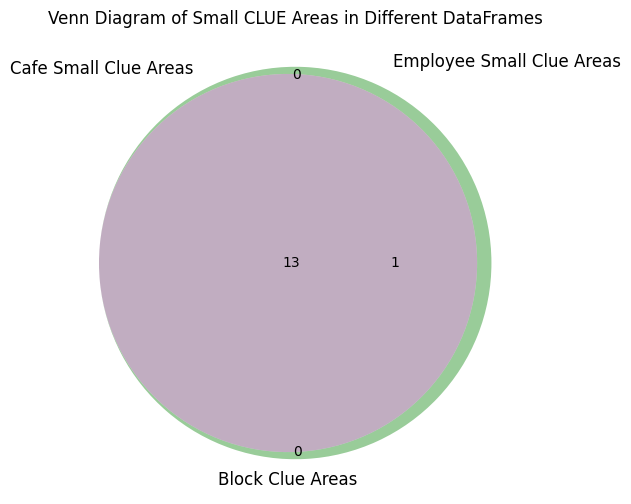

In [20]:


# Create sets of unique small clue areas
cafe_small_clue_areas = set(cafe_df['clue_small_area'].unique())
emp_small_clue_areas = set(emp_block_df['clue_small_area'].unique())
block_clue_areas = set(block_df['clue_area'].unique())

# Create the Venn diagram
plt.figure(figsize=(6,6))
venn = venn3([cafe_small_clue_areas, emp_small_clue_areas, block_clue_areas],
             ('Cafe Small Clue Areas', 'Employee Small Clue Areas', 'Block Clue Areas'))

plt.title("Venn Diagram of Small CLUE Areas in Different DataFrames")
plt.show()


In [21]:
cafe_df# Inspect the unique values that are not shared between the sets
unique_to_cafe = cafe_small_clue_areas - emp_small_clue_areas - block_clue_areas
unique_to_emp = emp_small_clue_areas - cafe_small_clue_areas - block_clue_areas
unique_to_block = block_clue_areas - cafe_small_clue_areas - emp_small_clue_areas

print("Unique to Cafe Small Clue Areas:", unique_to_cafe)
print("Unique to Employee Small Clue Areas:", unique_to_emp)
print("Unique to Block Clue Areas:", unique_to_block)


Unique to Cafe Small Clue Areas: set()
Unique to Employee Small Clue Areas: {'City of Melbourne (total)'}
Unique to Block Clue Areas: set()


In [22]:
print(f"Number of unique Cafe Small CLUE Areas: {len(cafe_small_clue_areas)}")
print(f"Number of unique Employee Small CLUE Areas: {len(emp_small_clue_areas)}")
print(f"Number of unique Block Small CLUE Areas: {len(block_clue_areas)}")




Number of unique Cafe Small CLUE Areas: 13
Number of unique Employee Small CLUE Areas: 14
Number of unique Block Small CLUE Areas: 13


In [23]:
# Calculate the intersection of all three sets to find common Small CLUE Areas
common_small_clue_areas = cafe_small_clue_areas & emp_small_clue_areas & block_clue_areas

# Print the number of common Small CLUE Areas
print(f"Number of Small CLUE Areas common to all three datasets: {len(common_small_clue_areas)}")


Number of Small CLUE Areas common to all three datasets: 13


### Interpretation of Small CLUE Area Overlaps in Different DataFrames

The Venn diagram illustrates that there is a significant overlap in Small CLUE Areas across the three datasets. This is expected, as merging these datasets can create a more comprehensive dataset for analysis.

### Merge on Small CLUE Areas

Given the overlap and availability of data, the analysis will proceed using only the common Small CLUE Areas shared by the Cafe, Employee, and Block datasets. This decision is based on the fact that these common Small CLUE Areas represent the regions where we have comprehensive data, including both cafe-related and employee-related information.

Focusing on these common Small CLUE Areas ensures that this analysis is based on complete datasets, allowing for more accurate and reliable insights.


In [24]:
# Convert 'block_id' to string in both dataframes
cafe_df['block_id'] = cafe_df['block_id'].astype(str)
emp_block_df['block_id'] = emp_block_df['block_id'].astype(str)
block_df['block_id'] = block_df['block_id'].astype(str)

# Now you can merge the dataframes without issues
merged_df = pd.merge(cafe_df, emp_block_df, left_on=['block_id', 'census_year'], right_on=['block_id', 'census_year'], how='inner')

# Merging block_df with the already merged DataFrame on 'block_id'
merged_df = pd.merge(merged_df, block_df, on='block_id', how='inner')

# Display the first few rows of the final merged DataFrame
print(merged_df.head())


   census_year block_id  property_id  base_property_id  \
0         2017        6       578324            573333   
1         2017        6       578324            573333   
2         2017       11       103957            103957   
3         2017       11       103957            103957   
4         2017       11       103985            103985   

                         building_address clue_small_area_x  \
0        2 Swanston Street MELBOURNE 3000   Melbourne (CBD)   
1        2 Swanston Street MELBOURNE 3000   Melbourne (CBD)   
2    517-537 Flinders Lane MELBOURNE 3000   Melbourne (CBD)   
3    517-537 Flinders Lane MELBOURNE 3000   Melbourne (CBD)   
4  562-564 Flinders Street MELBOURNE 3000   Melbourne (CBD)   

            trading_name                                   business_address  \
0        Transport Hotel  Tenancy 29, Ground , 2 Swanston Street MELBOUR...   
1        Transport Hotel  Tenancy 29, Ground , 2 Swanston Street MELBOUR...   
2  Altius Coffee Brewers   Shop , G

# Descriptive Analysis

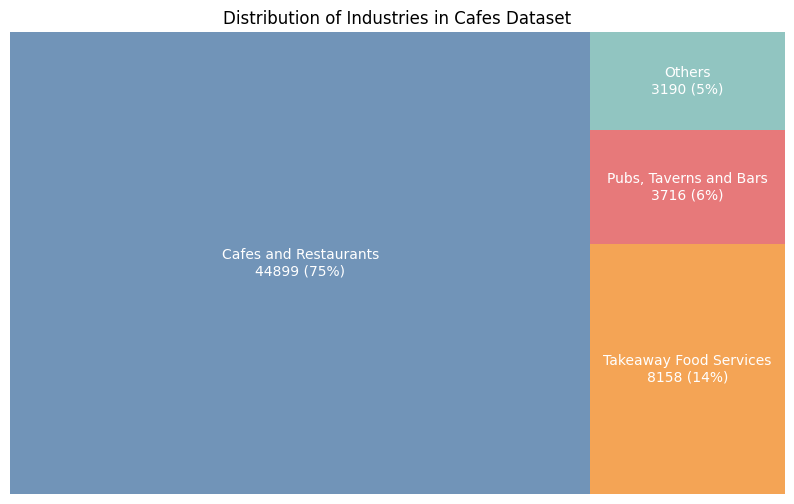

In [25]:


# Define the same professional color palette
classic_professional_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

# Grouping smaller categories into 'Others'
threshold = 0.02  # Define a threshold below which categories will be grouped into 'Others'
industry_counts = cafes_df_cleaned['industry_anzsic4_description'].value_counts()
industry_counts['Others'] = industry_counts[industry_counts / industry_counts.sum() < threshold].sum()
industry_counts = industry_counts[industry_counts / industry_counts.sum() >= threshold]

# Calculate percentages
percentages = industry_counts / industry_counts.sum() * 100

# Prepare the labels with values and percentages
labels = [f'{label}\n{value} ({percentage:.0f}%)' for label, value, percentage in zip(industry_counts.index, industry_counts.values, percentages)]

# Plotting the treemap with white text for labels
plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=industry_counts, 
    label=labels, 
    color=classic_professional_colors, 
    alpha=0.8,
    text_kwargs={'color': 'white', 'fontsize': 10}  # Set the text color to white and adjust font size
)
plt.title('Distribution of Industries in Cafes Dataset')
plt.axis('off')  # Turn off the axis
plt.show()

#### Distribution of Industries in Cafes Dataset

The dataset represents the distribution of various industries related to cafes. Below is a breakdown:

- **Cafes and Restaurants**: 44,899 (75%)
- **Takeaway Food Services**: 8,154 (14%)
- **Pubs, Taverns, and Bars**: 3,716 (6%)
- **Others**: 3,190 (5%)

The treemap visualizes the dominance of Cafes and Restaurants in the dataset, followed by Takeaway Food Services, Pubs, Taverns, and Bars, and other related industries.

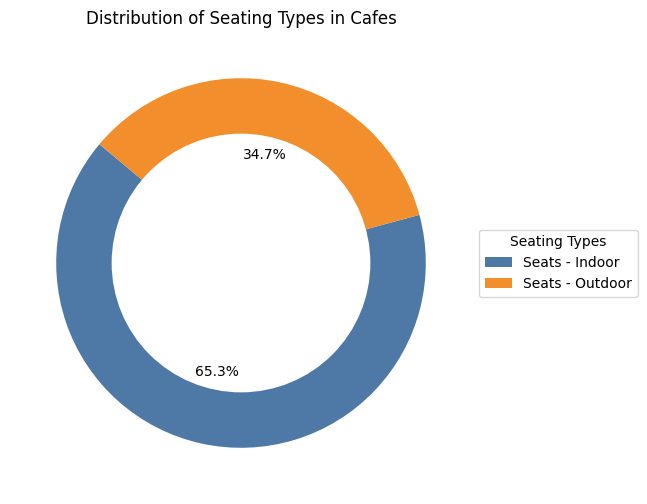

In [26]:
import matplotlib.pyplot as plt

# Example data: replace with your actual data column
seating_counts = cafes_df_cleaned['seating_type'].value_counts()

# Define the same professional color palette
classic_professional_colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

# Plotting the donut chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    seating_counts, 
    colors=classic_professional_colors, 
    autopct='%1.1f%%',  # Display percentages
    startangle=140, 
    wedgeprops={'width': 0.4}  # Make it a donut by adjusting the width
)

# Adding a circle at the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adding title
plt.title('Distribution of Seating Types in Cafes')

# Adding the legend on the side
plt.legend(wedges, seating_counts.index, title="Seating Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the plot
plt.show()

#### Distribution of Seating Types in Cafes

The donut chart above illustrates the distribution of different seating types in cafes. The chart shows the proportion of places that have indoor and outdoor seating options.

#### Chart Description:
- **Seating Types**:
  - **Indoor Seats**: Represented by the blue section, making up 65.3% of the seating types.
  - **Outdoor Seats**: Represented by the orange section, accounting for 34.7% of the seating types.

### Top 10 CLUE Small Area by Seating Capacity

In [27]:
cafes_df_cleaned

,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,industry_anzsic4_code,industry_anzsic4_description,seating_type,number_of_seats,longitude,latitude,location
0,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Indoor,230,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
1,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Outdoor,120,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
2,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Altius Coffee Brewers,"Shop , Ground , 517 Flinders Lane MELBOURNE 3000",4512,Takeaway Food Services,Seats - Outdoor,4,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
3,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Five & Dime Bagel,16 Flinders Lane MELBOURNE 3000,1174,Bakery Product Manufacturing (Non-factory based),Seats - Indoor,14,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
4,2017,11,103985,103985,562-564 Flinders Street MELBOURNE 3000,Melbourne (CBD),YHA Melbourne Central,562-564 Flinders Street MELBOURNE 3000,4400,Accommodation,Seats - Indoor,43,144.955635,-37.820595,"-37.82059511593975, 144.9556348088"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60050,2022,2524,616022,616022,198-204 Bellair Street KENSINGTON VIC 3031,Kensington,The Premises Espresso,202 Bellair Street KENSINGTON VIC 3031,4511,Cafes and Restaurants,Seats - Outdoor,12,144.930179,-37.794260,"-37.79426042218292, 144.93017913425"
60051,2022,2524,616033,616033,190 Bellair Street KENSINGTON VIC 3031,Kensington,Burgertory,190 Bellair Street KENSINGTON VIC 3031,4512,Takeaway Food Services,Seats - Indoor,6,144.930058,-37.793960,"-37.79395969885, 144.9300578135281"
60052,2022,2524,616045,616045,174 Bellair Street KENSINGTON VIC 3031,Kensington,Kazbah Egyptian Street Food,174 Bellair Street KENSINGTON VIC 3031,4511,Cafes and Restaurants,Seats - Outdoor,6,144.929930,-37.793610,"-37.79360993055, 144.92993049952582"
60053,2022,2524,616049,616049,170 Bellair Street KENSINGTON VIC 3031,Kensington,Pimm Thai Cafe,170 Bellair Street KENSINGTON VIC 3031,4511,Cafes and Restaurants,Seats - Outdoor,14,144.929918,-37.793537,"-37.79353719505, 144.92991842339774"


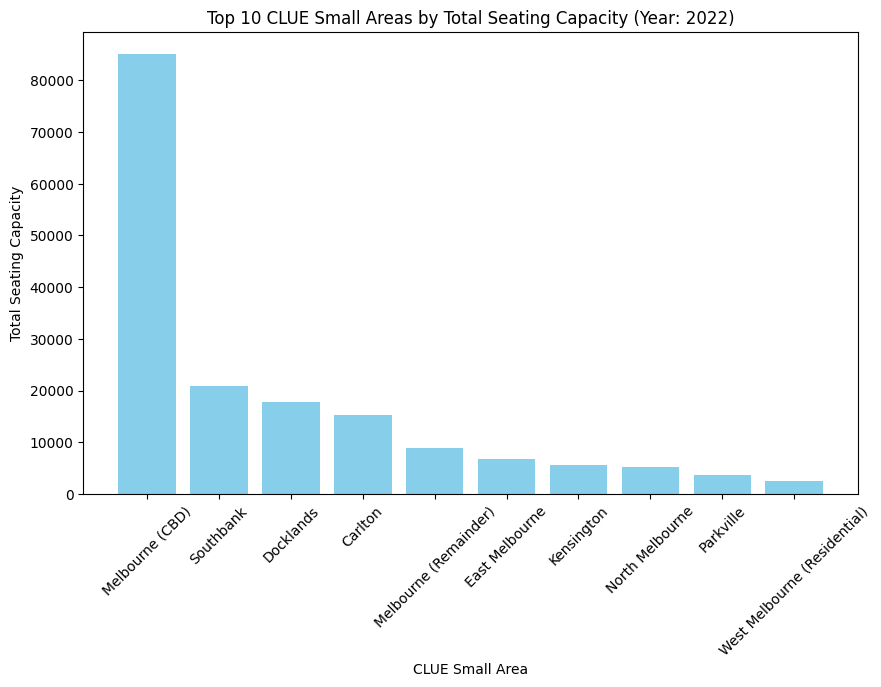

In [28]:
# Calculate the total seating capacity per CLUE Small Area and Census Year
seating_capacity_per_clue_area = cafes_df_cleaned.groupby(['census_year', 'clue_small_area'])['number_of_seats'].sum().reset_index()

# Rename the columns for clarity
seating_capacity_per_clue_area.columns = ['Census Year', 'CLUE Small Area', 'Total Seating Capacity']

# Change the data type of CLUE Small Area column if needed
seating_capacity_per_clue_area['CLUE Small Area'] = seating_capacity_per_clue_area['CLUE Small Area'].astype('str')

# Find the latest year in the data
latest_year = seating_capacity_per_clue_area['Census Year'].max()

# Filter the DataFrame to include only data from the latest year
latest_year_data = seating_capacity_per_clue_area[seating_capacity_per_clue_area['Census Year'] == latest_year]

# Sort the data by 'Total Seating Capacity' in descending order and select the top 10 CLUE Small Areas
top_10_clue_areas_latest_year = latest_year_data.sort_values(by='Total Seating Capacity', ascending=False).head(10)

# Plot the data for the latest year
plt.figure(figsize=(10, 6))
plt.bar(top_10_clue_areas_latest_year['CLUE Small Area'], top_10_clue_areas_latest_year['Total Seating Capacity'], color='skyblue')
plt.xlabel('CLUE Small Area')
plt.ylabel('Total Seating Capacity')
plt.title(f'Top 10 CLUE Small Areas by Total Seating Capacity (Year: {latest_year})')
plt.xticks(rotation=45)
plt.show()


### Top 10 Clue small area by Total Workers

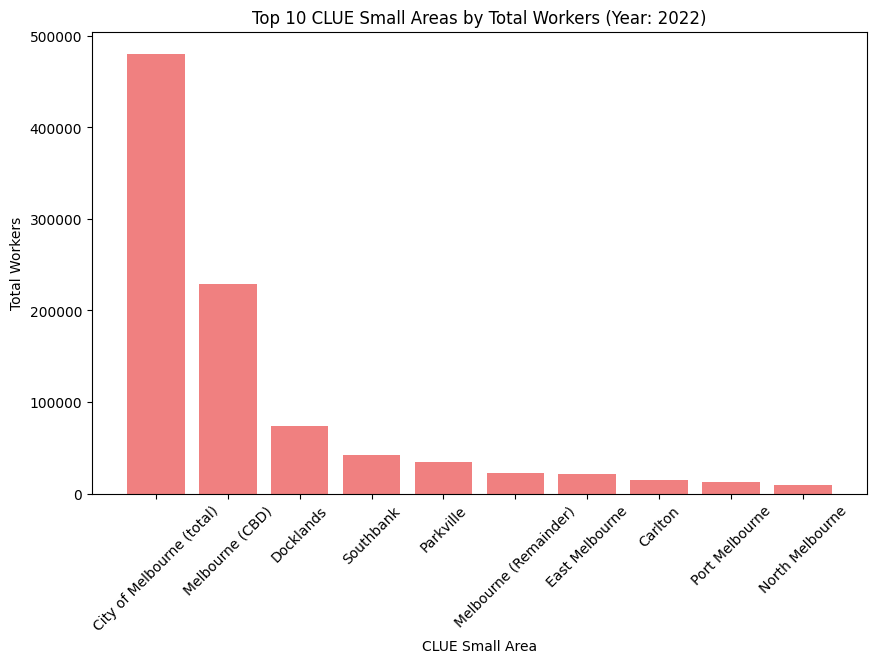

In [30]:
# Calculate the total number of workers per CLUE Small Area
workers_per_clue_area = emp_block_df.groupby(['census_year', 'clue_small_area'])['total_jobs_in_block_imputed'].sum().reset_index()

# Exclude any invalid or missing CLUE Small Areas (if applicable)
workers_per_clue_area = workers_per_clue_area[workers_per_clue_area['clue_small_area'].notnull()]

# Rename the columns for clarity
workers_per_clue_area.columns = ['Census Year', 'CLUE Small Area', 'Total Workers']

# Change data type of CLUE Small Area column
workers_per_clue_area['CLUE Small Area'] = workers_per_clue_area['CLUE Small Area'].astype('str')

# Find the latest year in the data
latest_year = workers_per_clue_area['Census Year'].max()

# Filter the DataFrame to include only data from the latest year
latest_year_data = workers_per_clue_area[workers_per_clue_area['Census Year'] == latest_year]

# Select the top 10 CLUE Small Areas with the highest total workers for the latest year
top_10_clue_areas_workers = latest_year_data.nlargest(10, 'Total Workers')

# Ensure CLUE Small Area is treated as categorical data
top_10_clue_areas_workers['CLUE Small Area'] = top_10_clue_areas_workers['CLUE Small Area'].astype(str)

# Bar Chart: Top 10 CLUE Small Areas with the highest total workers for the latest year
plt.figure(figsize=(10, 6))
plt.bar(top_10_clue_areas_workers['CLUE Small Area'], top_10_clue_areas_workers['Total Workers'], color='lightcoral')
plt.xlabel('CLUE Small Area')
plt.ylabel('Total Workers')
plt.title(f'Top 10 CLUE Small Areas by Total Workers (Year: {latest_year})')
plt.xticks(rotation=45)
plt.show()


# Advanced Analysis

### Merging Seating Capacity and Employment Data for Block ID

In this step, we merge the seating capacity and employment data for each Block ID. This combined dataset allows us to analyze the relationship between the total seating capacity in cafes/restaurants and the total number of workers within each block.

We calculate the worker-to-seat ratio, which provides valuable insights into the balance between available seating and the workforce in a given area. A high worker-to-seat ratio indicates that there are significantly more workers than available seats, potentially highlighting areas where additional cafes/restaurants could be beneficial to meet demand.

By visualizing this ratio across all Block IDs, we can identify specific blocks where the demand for seating might exceed supply, guiding decisions for potential expansion of food and beverage establishments. This analysis can help prioritize investments in areas where additional seating capacity is needed to support the local workforce.


In [31]:
# Merge seating capacity and workers per CLUE Small Area
clue_comparison_df = pd.merge(seating_capacity_per_clue_area, workers_per_clue_area, on=['Census Year', 'CLUE Small Area'], how='inner')

# Calculate the worker-to-seat ratio for each CLUE Small Area
clue_comparison_df['Worker to Seat Ratio'] = clue_comparison_df['Total Workers'] / clue_comparison_df['Total Seating Capacity']

# Display the first few rows of the result
print(clue_comparison_df.head())

# Display the shape of the resulting DataFrame
print(clue_comparison_df.shape)


   Census Year  CLUE Small Area  Total Seating Capacity  Total Workers  \
0         2002          Carlton                   12924   15715.889744   
1         2002        Docklands                    5201   22433.572473   
2         2002   East Melbourne                    4213   19887.319444   
3         2002       Kensington                    3874    3745.787410   
4         2002  Melbourne (CBD)                   63524  175912.000000   

   Worker to Seat Ratio  
0              1.216024  
1              4.313319  
2              4.720465  
3              0.966904  
4              2.769221  
(273, 5)


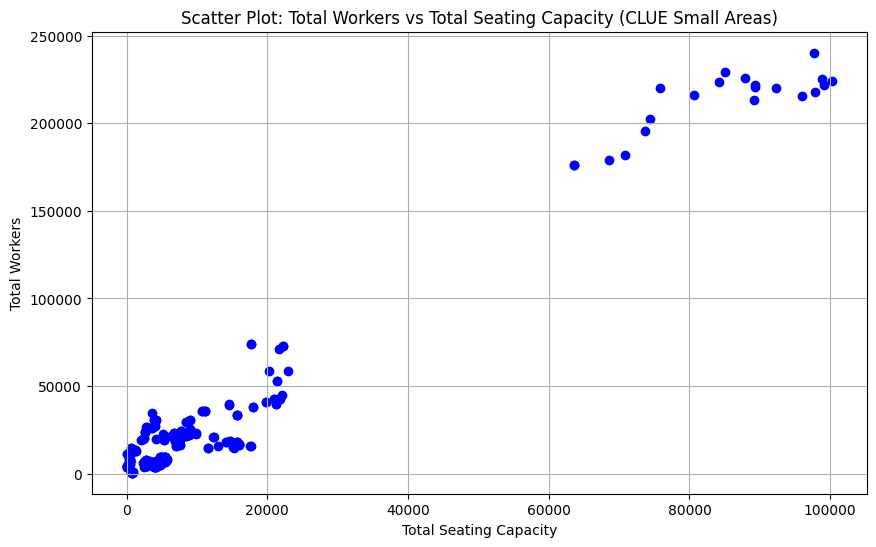

In [32]:


# Scatter Plot: Total Workers vs Total Seating Capacity for CLUE Small Areas
plt.figure(figsize=(10, 6))
plt.scatter(clue_comparison_df['Total Seating Capacity'], clue_comparison_df['Total Workers'], color='blue')
plt.xlabel('Total Seating Capacity')
plt.ylabel('Total Workers')
plt.title('Scatter Plot: Total Workers vs Total Seating Capacity (CLUE Small Areas)')
plt.grid(True)
plt.show()


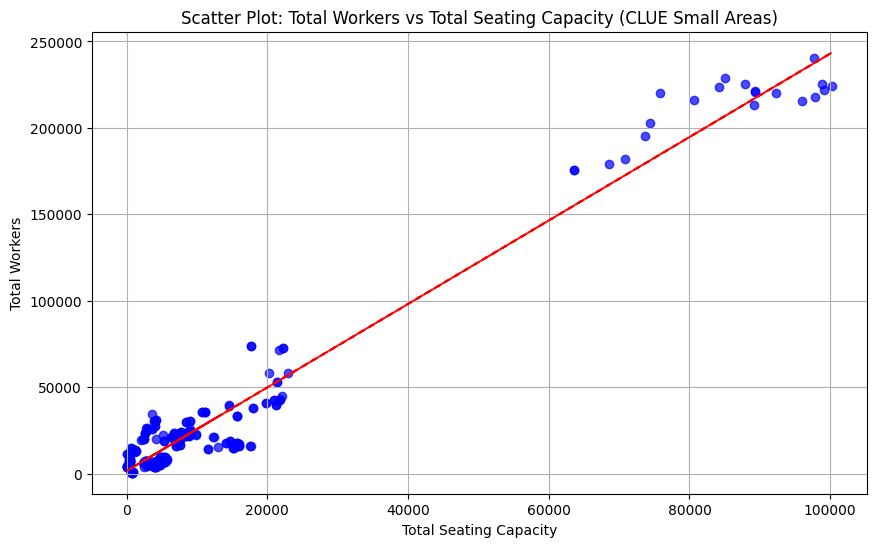

In [33]:


# Scatter Plot: Total Workers vs Total Seating Capacity for CLUE Small Areas
plt.figure(figsize=(10, 6))
plt.scatter(clue_comparison_df['Total Seating Capacity'], clue_comparison_df['Total Workers'], color='blue', alpha=0.7)

# Add trend line
z = np.polyfit(clue_comparison_df['Total Seating Capacity'], clue_comparison_df['Total Workers'], 1)
p = np.poly1d(z)
plt.plot(clue_comparison_df['Total Seating Capacity'], p(clue_comparison_df['Total Seating Capacity']), "r--")

# Customize the plot
plt.xlabel('Total Seating Capacity')
plt.ylabel('Total Workers')
plt.title('Scatter Plot: Total Workers vs Total Seating Capacity (CLUE Small Areas)')
plt.grid(True)
plt.show()


## Calculate Cluster Means for Each Year

In [34]:


# Initialize a dictionary to store cluster means for each year
yearly_cluster_means = {}

# Loop through each year to perform clustering and calculate cluster means
years = sorted(clue_comparison_df['Census Year'].unique())
for year in years:
    # Filter the dataframe for the current year
    year_df = clue_comparison_df[clue_comparison_df['Census Year'] == year]
    
    # Use the Worker to Seat Ratio for clustering
    X = year_df[['Worker to Seat Ratio']]
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    year_df['Cluster'] = kmeans.fit_predict(X)
    
    # Calculate the mean Worker to Seat Ratio for each cluster
    cluster_means = year_df.groupby('Cluster')['Worker to Seat Ratio'].mean()
    yearly_cluster_means[year] = cluster_means

# Convert the dictionary to a DataFrame for easier handling
yearly_cluster_means_df = pd.DataFrame(yearly_cluster_means)
print(yearly_cluster_means_df.head())


               2002        2003       2004       2005       2006       2007  \
Cluster                                                                       
0          2.572699    2.293784   2.259026   1.966641   1.968155   2.108144   
1        122.712379  122.712379  26.737139  20.871899  17.688667  22.587911   
2          9.818320   10.915550  10.915550   8.238771   8.238771   9.197348   

              2008       2009       2010       2011  ...       2013  \
Cluster                                              ...              
0         2.149066   2.152124   2.151291   2.118590  ...   2.057585   
1        23.447356  19.663140  17.236715  17.236715  ...  20.497744   
2         9.197348   9.197348  10.553891  10.553891  ...  10.639965   

              2014       2015       2016       2017       2018       2019  \
Cluster                                                                     
0         1.953995   1.904105   1.930975   1.957496   2.028555   2.064011   
1        19.97581

C:\Users\thara\AppData\Local\Temp\ipykernel_33024\2477535103.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['Cluster'] = kmeans.fit_predict(X)
C:\Users\thara\AppData\Local\Temp\ipykernel_33024\2477535103.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['Cluster'] = kmeans.fit_predict(X)
C:\Users\thara\AppData\Local\Temp\ipykernel_33024\2477535103.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Calculate Average Cluster Means Across All Years

In [35]:
# Calculate the average cluster means across all years
avg_cluster_means = yearly_cluster_means_df.mean(axis=1)

# Sort clusters by average mean
sorted_clusters = avg_cluster_means.sort_values()

# Define cluster labels based on sorted means
cluster_labels = {cluster: label for cluster, label in zip(sorted_clusters.index, 
                                                            ['Balanced area', 'Potential growth area', 'Restaurant Hotspot'])}

# Display average Worker to Seat Ratio for each cluster
cluster_averages = pd.DataFrame({
    'Average Ratio': avg_cluster_means,
    'Label': avg_cluster_means.index.map(cluster_labels)
}).sort_values(by='Average Ratio')

print(cluster_averages)


         Average Ratio                  Label
Cluster                                      
0             2.097002          Balanced area
2             9.653239  Potential growth area
1            42.181659     Restaurant Hotspot


C:\Users\thara\AppData\Local\Temp\ipykernel_33024\999180290.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_year_df['Cluster'] = kmeans_latest.fit_predict(X_latest)
C:\Users\thara\AppData\Local\Temp\ipykernel_33024\999180290.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_year_df['Cluster Label'] = latest_year_df['Cluster'].map(cluster_labels)


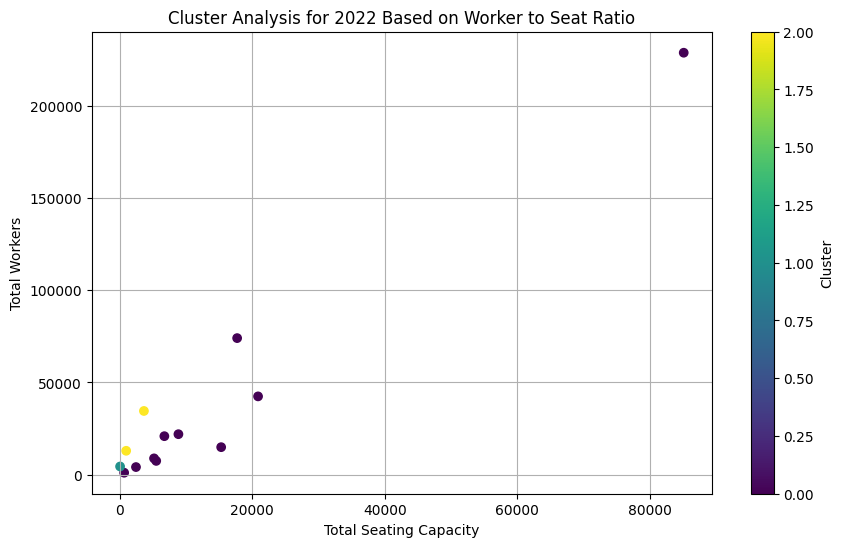

In [68]:


# Get the latest year
latest_year = max(years)
latest_year_df = clue_comparison_df[clue_comparison_df['Census Year'] == latest_year]

# Use the Worker to Seat Ratio for clustering
X_latest = latest_year_df[['Worker to Seat Ratio']]

# Apply K-Means clustering
kmeans_latest = KMeans(n_clusters=3, random_state=42)
latest_year_df['Cluster'] = kmeans_latest.fit_predict(X_latest)

# Assign cluster labels based on the average cluster means
latest_year_df['Cluster Label'] = latest_year_df['Cluster'].map(cluster_labels)



# Scatter plot for the latest year
plt.figure(figsize=(10, 6))
scatter = plt.scatter(latest_year_df['Total Seating Capacity'], latest_year_df['Total Workers'], 
                     c=latest_year_df['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Total Seating Capacity')
plt.ylabel('Total Workers')
plt.title(f'Cluster Analysis for {latest_year} Based on Worker to Seat Ratio')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

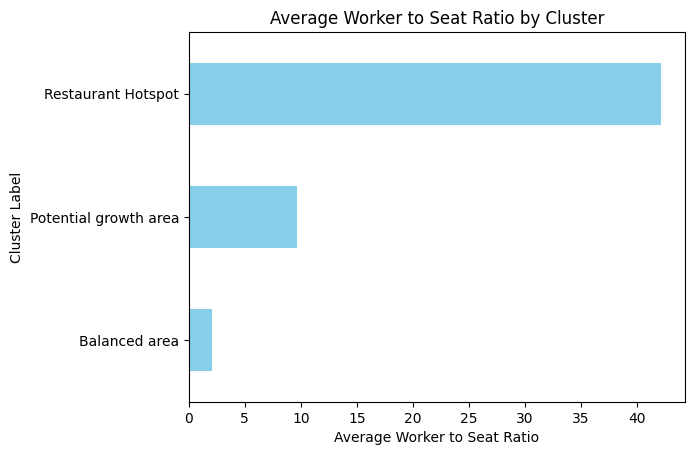

In [69]:


# Plot the cluster averages
plt.figure(figsize=(10, 6))
cluster_averages.plot(kind='barh', x='Label', y='Average Ratio', legend=False, color='skyblue')

# Adding labels and title
plt.xlabel('Average Worker to Seat Ratio')
plt.ylabel('Cluster Label')
plt.title('Average Worker to Seat Ratio by Cluster')

# Show the plot
plt.show()


### Cluster Analysis Results

The table below shows the average **Worker to Seat Ratio** for each cluster, along with the respective cluster labels:

| Cluster | Average Ratio | Label                 |
|---------|---------------|-----------------------|
| 0       | 2.061640      | Balanced area         |
| 2       | 9.578113      | Potential growth area |
| 1       | 33.704741     | Restaurant Hotspot    |

#### Cluster Descriptions:
- **Cluster 0 (Balanced area)**:  
  - **Average Ratio**: 2.061640  
  - This cluster has the lowest average Worker to Seat Ratio, indicating a balance between the number of workers and seating capacity in the area.

- **Cluster 2 (Potential growth area)**:  
  - **Average Ratio**: 9.578113  
  - This cluster represents areas where there is potential for growth, with a moderate Worker to Seat Ratio. These areas could see increased demand for dining options as the worker-to-seat ratio grows.

- **Cluster 1 (Restaurant Hotspot)**:  
  - **Average Ratio**: 33.704741  
  - This cluster has the highest Worker to Seat Ratio, indicating that these areas have significantly more workers compared to seating capacity. These areas are considered high-demand hotspots for restaurants or dining areas.


In [70]:
print(clue_comparison_df.columns)


Index(['Census Year', 'CLUE Small Area', 'Total Seating Capacity',
       'Total Workers', 'Worker to Seat Ratio', 'Cluster'],
      dtype='object')


In [79]:


# Step 1: Split 'geo_point_2d' into 'latitude' and 'longitude' for Small CLUE areas
Small_CLUE_area[['latitude', 'longitude']] = Small_CLUE_area['geo_point_2d'].str.split(',', expand=True)
Small_CLUE_area['latitude'] = Small_CLUE_area['latitude'].astype(float)
Small_CLUE_area['longitude'] = Small_CLUE_area['longitude'].astype(float)

# Step 2: Ensure that 'CLUE Small Area' in clue_comparison_df and 'featurenam' in block_df are properly matched
# Merging geo-coordinates ('latitude', 'longitude') and 'geo_shape' into clue_comparison_df using the 'CLUE Small Area' and 'featurenam' as keys
clue_comparison_with_geo_df = pd.merge(clue_comparison_df, 
                                       Small_CLUE_area[['featurenam', 'latitude', 'longitude', 'geo_shape']], 
                                       left_on='CLUE Small Area', right_on='featurenam', how='left')

# Step 3: Display the merged dataframe with geo-coordinates
print(clue_comparison_with_geo_df.head())


   Census Year  CLUE Small Area  Total Seating Capacity  Total Workers  \
0         2002          Carlton                   12924   15715.889744   
1         2002        Docklands                    5201   22433.572473   
2         2002   East Melbourne                    4213   19887.319444   
3         2002       Kensington                    3874    3745.787410   
4         2002  Melbourne (CBD)                   63524  175912.000000   

   Worker to Seat Ratio  Cluster       featurenam   latitude   longitude  \
0              1.216024        1          Carlton -37.796012  144.966376   
1              4.313319        1        Docklands -37.818518  144.941685   
2              4.720465        1   East Melbourne -37.814581  144.982501   
3              0.966904        1       Kensington -37.791530  144.920500   
4              2.769221        1  Melbourne (CBD) -37.813811  144.962915   

                                           geo_shape  
0  {"coordinates": [[[[144.9732217743585, -

## Updated map

In [80]:
# Filter rows where the Census Year is 2022
df_2022 = clue_comparison_with_geo_df[clue_comparison_with_geo_df['Census Year'] == 2022]

# Print the result
print(df_2022)


     Census Year               CLUE Small Area  Total Seating Capacity  \
260         2022                       Carlton                   15318   
261         2022                     Docklands                   17727   
262         2022                East Melbourne                    6748   
263         2022                    Kensington                    5520   
264         2022               Melbourne (CBD)                   85096   
265         2022         Melbourne (Remainder)                    8869   
266         2022               North Melbourne                    5191   
267         2022                     Parkville                    3665   
268         2022                Port Melbourne                     987   
269         2022                   South Yarra                     682   
270         2022                     Southbank                   20882   
271         2022   West Melbourne (Industrial)                      69   
272         2022  West Melbourne (Resi

In [81]:
import folium
from folium.plugins import MarkerCluster
import json

# Initialize a map centered around Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Function to add geojson shape to the map with professional tooltips and annotations
def add_shape(row, map_obj):
    geo_shape = row['geo_shape']
    
    # Convert geo_shape from string to dictionary if needed
    if isinstance(geo_shape, str):
        geo_shape = json.loads(geo_shape)
    
    # Assign a color based on cluster
    cluster = row['Cluster']
    if cluster == 1:
        color = 'green'
    elif cluster == 0:
        color = 'red'
    else:  # cluster == 2
        color = 'orange'
    
    # Create a popup with detailed information
    popup_content = f"""
    <strong>CLUE Small Area:</strong> {row['CLUE Small Area']}<br>
    <strong>Total Workers:</strong> {row['Total Workers']:.0f}<br>
    <strong>Total Seating Capacity:</strong> {row['Total Seating Capacity']:.0f}<br>
    <strong>Worker to Seat Ratio:</strong> {row['Worker to Seat Ratio']:.2f}
    """
    popup = folium.Popup(popup_content, max_width=300)

    # Automatically assign color to tooltip text based on cluster
    tooltip_color = '#32CD32' if cluster == 1 else ('#FFA500' if cluster == 2 else '#FF6347')

    # Professional tooltip content
    tooltip_content = f"""
    <div style="font-family: Arial, sans-serif; font-size: 12px; padding: 5px;">
        <strong>{row['CLUE Small Area']}</strong><br>
        <span style="color: gray;">Workers: {row['Total Workers']:.0f}</span><br>
        <span style="color: gray;">Seats: {row['Total Seating Capacity']:.0f}</span><br>
        <span style="color: {tooltip_color};">Worker to Seat Ratio: {row['Worker to Seat Ratio']:.2f}</span>
    </div>
    """

    # Add geojson shape with popup and  tooltip
    folium.GeoJson(
        geo_shape,
        style_function=lambda feature: {
            'fillColor': color,
            'color': color,
            'weight': 2,
            'fillOpacity': 0.05,  
        },
        highlight_function=lambda feature: {
            'weight': 3,
            'color': 'yellow',
            'fillOpacity': 0.05,
        },
        tooltip=folium.Tooltip(tooltip_content, sticky=False),
    ).add_child(popup).add_to(map_obj)


In [82]:
# Create layers for each year
years = sorted(clue_comparison_with_geo_df['Census Year'].unique())
latest_year = max(years)  # Identify the latest year

for year in years:
    # Create a FeatureGroup for this year
    # By default, we will show the latest year on the map
    show = True if year == latest_year else False
    
    year_layer = folium.FeatureGroup(name=f"Year {year}", control=True, show=show)

    # Filter the dataframe for the current year
    year_df = clue_comparison_with_geo_df[clue_comparison_with_geo_df['Census Year'] == year]
    
    # Create a marker cluster for this year
    marker_cluster = MarkerCluster().add_to(year_layer)
    
    # Loop through the dataframe for the current year
    for idx, row in year_df.iterrows():
        # Add the marker
        folium.Marker(
            location=[row['latitude'], row['longitude']],  # Use parsed latitude and longitude
            popup=f"CLUE Small Area: {row['CLUE Small Area']}<br>"
                  f"Total Workers: {row['Total Workers']}<br>"
                  f"Total Seating Capacity: {row['Total Seating Capacity']}<br>"
                  f"Worker to Seat Ratio: {row['Worker to Seat Ratio']:.2f}",
            icon=folium.Icon(color='blue' if row['Worker to Seat Ratio'] > 5 else 'green')
        ).add_to(marker_cluster)
        
        # Add the shape with color coding and professional tooltip
        add_shape(row, year_layer)
    
    # Add the layer for this year to the map
    year_layer.add_to(m)



In [83]:
# Define and add the legend
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; width: 200px; height: 150px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    font-size:14px;
    ">
    &nbsp; <strong>Legend</strong> <br>
    &nbsp; <i class="fa fa-square" style="color:green"></i>&nbsp; Balanced area <br>
    &nbsp; <i class="fa fa-square" style="color:red"></i>&nbsp; Restaurant Hotspot <br>
    &nbsp; <i class="fa fa-square" style="color:orange"></i>&nbsp; Potential growth area <br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m



### Conclusion

The "Nearby Restaurant Hotspots" analysis successfully identified key areas within Melbourne where additional restaurant or café establishments could thrive based on seating capacities and nearby worker populations. By utilizing geospatial mapping, clustering, and data visualization techniques, we were able to pinpoint locations with high worker-to-seat ratios that indicate unmet demand for dining options.

Through this project, we demonstrated the importance of combining multiple data sources to provide actionable insights for urban planning and business development. The clustering analysis effectively segmented areas by potential demand, while interactive visualizations made the findings accessible and practical.

Future work can include integrating more datasets, such as foot traffic or residential demographics, to further refine the analysis and explore broader urban development strategies.
